**Neste notebook, estaremos implementando um método de diferenciação fracionada conforme apresentado no livro "Advances in Financial Machine Learning" de Marcos Lopez de Prado. Em suma, nosso objetivo é converter uma série temporal não estacionária em uma série estacionária através da transformada da diferenciação fracionada, mantendo parcialmente parte da memória da série temporal original. Essa transformação resultará em uma nova série temporal que será mais adequada para uso em algoritmos de machine learning e modelos ARIMA.**


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels
from statsmodels.tsa.stattools import adfuller

sns.set_theme(style="whitegrid")

In [ ]:
def getWeights(d,size):
    '''
    d:fraction
    k:the number of samples
    w:weight assigned to each samples

    '''
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1) #sort and reshape the w
    return w

In [ ]:
def set_weight_drange(dRange, nPlots=11, size=6):

#dRange: intervalo de valores para 'd'
#nPlots: quantidade de valores 'd'que vamos plotar
#size: quantidade de pontos usados para cada ordem de diferenciação 'd'
#w: pesos da diferenciações


    w=pd.DataFrame()

    for d in np.linspace(dRange[0],dRange[1],nPlots):
        w_=getWeights(d,size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')

    return w

In [ ]:
def getWeights_FFD(d, thres):

    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)

In [ ]:
#Faz a transformação em uma coluna (ou uma  Series)
def diff_col(col,d,thres):
    #3) Aplicando os pesos na coluna
    w=getWeights_FFD(d,thres)
    width=len(w)-1

    df = pd.Series(dtype=float)
    #Evitando que o dataframe transformado fique maior que o original
    if width >= col.shape[0]:raise Exception("width is oversize")

    for i in range(width, col.shape[0]):
        i_0_index, i_1_index = col.index[i-width], col.index[i]
        data = np.dot(w.T, col.loc[i_0_index:i_1_index])[0]

        df[i_1_index] = data

    return df

In [ ]:
#função retirada do site
# https://medium.com/swlh/fractionally-differentiated-features-9c1947ed2b55
def get_adf_corr():
    adfstat=pd.DataFrame(columns=['adfStat','pVal','lags',
                             'nObs','95% conf','corr'])

    for d in np.linspace(0, 1 , 11):
        price_trans = diff_col( vale['Close'],d=d,thres=0.001)
        corr = price_corr_np = np.corrcoef(vale['Close'].loc[price_trans.index],
                                           price_trans)[0,1]
        adf=adfuller(price_trans, maxlag=1, regression='c',autolag=None)
        adfstat.loc[d]=list(adf[:4])+[adf[4]['5%']]+[corr]

    return adfstat

Tamanho do dataframe: (1990, 6)


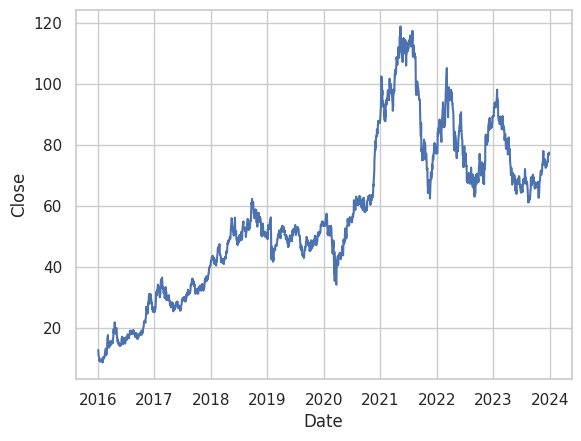

In [ ]:
#Carregando o dataframe com os preços das ações da vale
vale = pd.read_csv('/content/drive/MyDrive/2023/dados/VALE3.SA.csv',
                parse_dates=True,
                index_col='Date')
print('Tamanho do dataframe:',vale.shape)
sns.lineplot(vale['Close']);

In [ ]:
#acessando o final do dataframe para confirmar as últimas observações de data
vale.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-21,75.449997,77.050003,75.320000,76.970001,76.970001,24202600
2023-12-22,77.129997,78.199997,76.290001,76.389999,76.389999,26277000
2023-12-26,77.160004,77.449997,76.660004,76.660004,76.660004,12149500
2023-12-27,76.849998,77.550003,76.849998,77.400002,77.400002,13821200
2023-12-28,77.000000,77.459999,76.750000,77.199997,77.199997,16545800


**Diferenciação fracionada:**

$𝕏_{t} = \sum_{i=1}^n ω_{k} * X_{t-k} = ω_{0} * X_{t}+
ω_{1} * X_{t-1}+ω_{2} * X_{t-2}+... $

$ω_{k} = (-1)^k ∏_{0}^{k-1}\frac{d-i}{k!} $

 $ω = $ {1,-d, $\frac{d(d-1)}{2!}$,$\frac{d(d-1)(d-2)}{3!}$,... }

* $X_{t}$ : **Valor no instante de tempo t**
* $𝕏_{t}$ : **Valor transformado no instante de tempo t**
* $ω_{k}$: **pesos da transformada**
* **d: ordem da diferenciação**

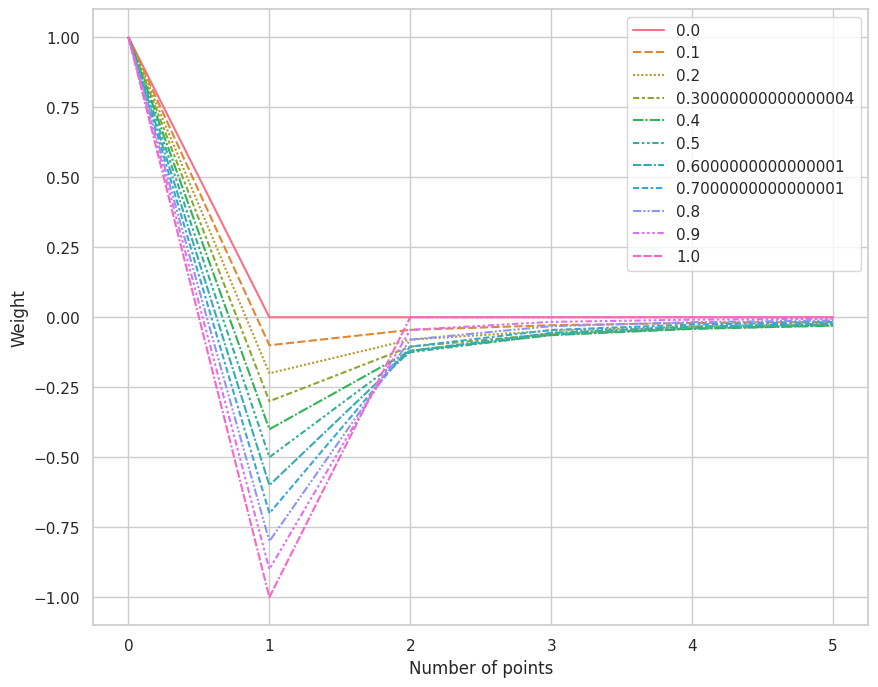

In [ ]:
#Eixo X representa a quantidade de dados que os pesos interagem
#Eixo Y representa o valor do peso
plt.figure(figsize=(10,8))
w = set_weight_drange([0,1])
sns.lineplot(data=w)
plt.legend(loc='best')
plt.xlabel('Number of points')
plt.ylabel('Weight');

**Ordem 0 e 1 de diferenciação**

$d=0 : 𝕏_{t} = 1*X_{t} + 0 = X_{t} $

$d=1 : 𝕏_{t} = 1*X_{t} + (-1)*X_{t-1}$

* **para d=0 o dado transformado é igual ao dado original**

* **para d=1 a diferenciação ocorre até uma data antes do dado do instante t**

In [ ]:
#dataframe com 1990 pontos e notamos que existe um valor de peso diferente de
#zero nas colunas de diferenciação no intervalo [0.1,0.9]
set_weight_drange([0,1],size=1990)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
1989,-0.0,-0.000022,-0.000019,-0.000012,-0.000006,-0.000003,-0.000001,-5.776301e-07,-2.012853e-07,-5.113079e-08,0.0
1988,-0.0,-0.000022,-0.000019,-0.000012,-0.000006,-0.000003,-0.000001,-5.781242e-07,-2.014676e-07,-5.117968e-08,0.0
1987,-0.0,-0.000022,-0.000019,-0.000012,-0.000006,-0.000003,-0.000001,-5.786190e-07,-2.016502e-07,-5.122864e-08,0.0
1986,-0.0,-0.000022,-0.000019,-0.000012,-0.000006,-0.000003,-0.000001,-5.791145e-07,-2.018331e-07,-5.127767e-08,0.0
1985,-0.0,-0.000022,-0.000019,-0.000012,-0.000006,-0.000003,-0.000001,-5.796106e-07,-2.020162e-07,-5.132677e-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4,-0.0,-0.020662,-0.033600,-0.040163,-0.041600,-0.039062,-0.033600,-2.616250e-02,-1.760000e-02,-8.662500e-03,0.0
3,-0.0,-0.028500,-0.048000,-0.059500,-0.064000,-0.062500,-0.056000,-4.550000e-02,-3.200000e-02,-1.650000e-02,0.0
2,-0.0,-0.045000,-0.080000,-0.105000,-0.120000,-0.125000,-0.120000,-1.050000e-01,-8.000000e-02,-4.500000e-02,0.0
1,-0.0,-0.100000,-0.200000,-0.300000,-0.400000,-0.500000,-0.600000,-7.000000e-01,-8.000000e-01,-9.000000e-01,-1.0


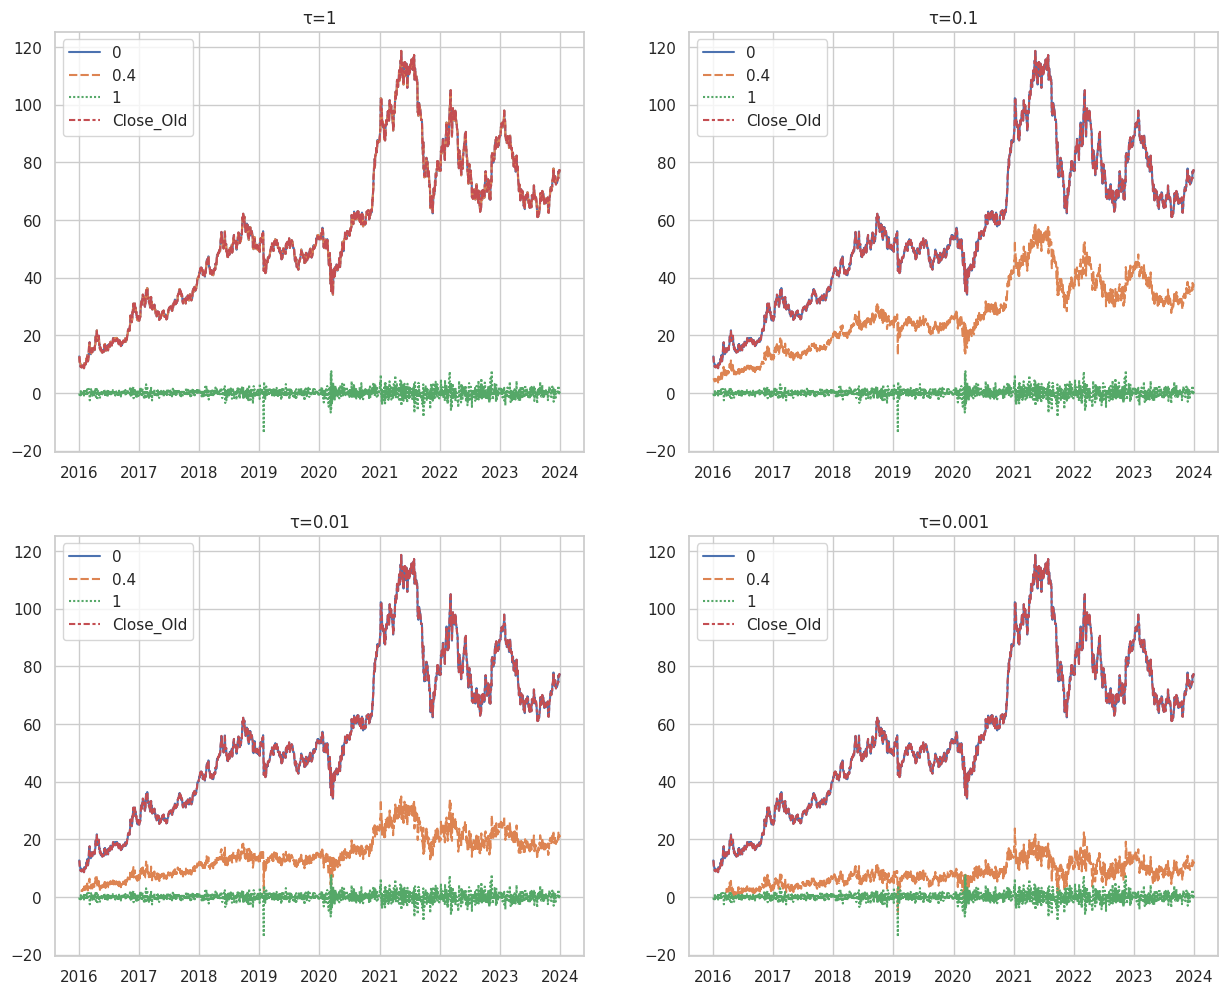

In [ ]:
#Dataframes que vão receber os dados transformados com um limite de pesos usados
data1 = pd.DataFrame()
data01 = pd.DataFrame()
data001 = pd.DataFrame()
data0001 = pd.DataFrame()

#Loop que irá transformar os dados de acordo com a tolerância no valor dos pesos
for d in [0,0.4,1]:
  data1[str(d)] = diff_col(vale['Close'],d,1)
  data01[str(d)] = diff_col(vale['Close'],d,0.1)
  data001[str(d)] = diff_col(vale['Close'],d,0.01)
  data0001[str(d)] = diff_col(vale['Close'],d,0.001)

#Apenas colocando o valores das ações sem a transformação nos dataframes
data1['Close_Old'] = vale['Close']
data01['Close_Old'] = vale['Close']
data001['Close_Old'] = vale['Close']
data0001['Close_Old'] = vale['Close']

#Ajeitando os gráficos para comparação da transformação de acordo com a ordem de
#diferenciação e o limite do valor dos pesos.
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.lineplot(data1)
plt.title('τ=1')
plt.subplot(2,2,2)
sns.lineplot(data01)
plt.title('τ=0.1')
plt.subplot(2,2,3)
sns.lineplot(data001)
plt.title('τ=0.01')
plt.subplot(2,2,4)
sns.lineplot(data0001)
plt.title('τ=0.001');

**'Close_old' são os dados iniciais sem a transformação**

In [ ]:
#valores de correlação são aceitos até 80%
#Pvalue abaixo de 0.05 para uma timeseries ser considerada estacionária
#tabela feita com limite de valor para o peso de 0.001
adfstat = get_adf_corr()
print('Valor médio da coluna 95% conf: ',adfstat['95% conf'].mean())
adfstat[['adfStat','95% conf','pVal','corr']]

Valor médio da coluna 95% conf:  -2.863021075640569


,adfStat,95% conf,pVal,corr
0.0,-1.709120,-2.862995,4.264200e-01,1.000000
0.1,-2.173456,-2.863041,2.160200e-01,0.997298
0.2,-3.006341,-2.863050,3.430646e-02,0.982144
0.3,-4.610015,-2.863044,1.237891e-04,0.949601
0.4,-6.876233,-2.863036,1.472190e-09,0.894122
0.5,-9.959554,-2.863027,2.393713e-17,0.807733
0.6,-13.876915,-2.863020,6.313831e-26,0.685785
0.7,-18.532761,-2.863013,2.102135e-30,0.532588
0.8,-23.299961,-2.863008,0.000000e+00,0.387513
0.9,-28.312394,-2.863003,0.000000e+00,0.228423


In [ ]:
#Primeira linha apresenta a menor ordem de diferenciação que irá preservar
#o máximo de memória após a transformada no dado
adfstat[adfstat['95% conf']<adfstat['95% conf'].mean()].sort_values(by='95% conf')

,adfStat,pVal,lags,nObs,95% conf,corr
0.2,-3.006341,3.430646e-02,1.0,1916.0,-2.863050,0.982144
0.3,-4.610015,1.237891e-04,1.0,1923.0,-2.863044,0.949601
0.1,-2.173456,2.160200e-01,1.0,1927.0,-2.863041,0.997298
0.4,-6.876233,1.472190e-09,1.0,1934.0,-2.863036,0.894122
0.5,-9.959554,2.393713e-17,1.0,1945.0,-2.863027,0.807733


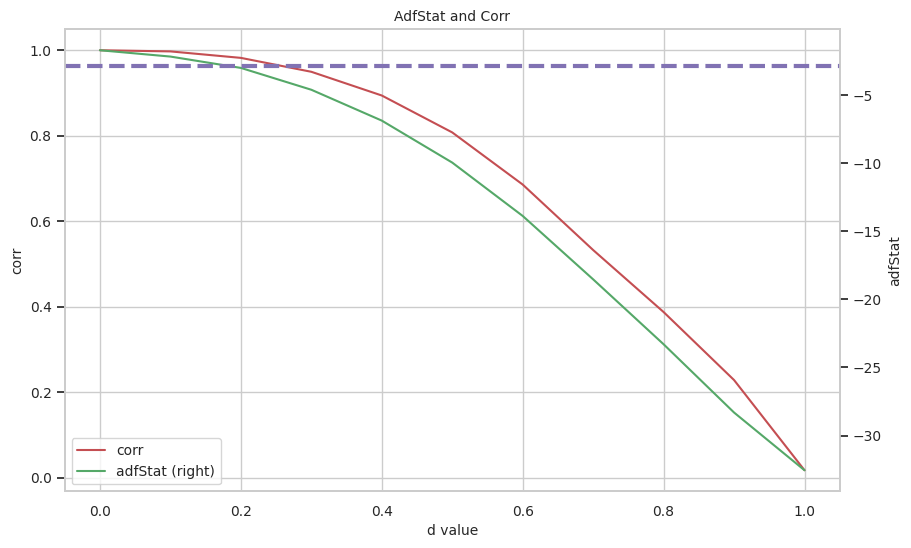

In [ ]:
ax1 = adfstat['corr'].plot(figsize=(10,6), color='r')
ax2 = adfstat['adfStat'].plot(secondary_y=True, fontsize=10, color='g', ax=ax1)
ax1.set_title('AdfStat and Corr', fontsize=10)
ax1.set_xlabel('d value', fontsize=10)
ax1.set_ylabel('corr', fontsize=10)
ax2.set_ylabel('adfStat', fontsize=10)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=10)
plt.axhline(adfstat['95% conf'].mean(),linewidth=3, color='m',linestyle='--');

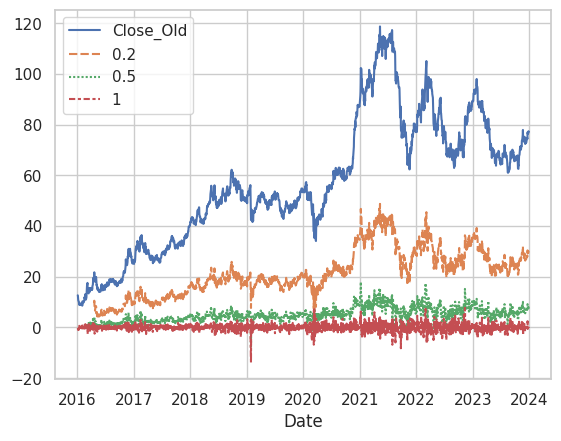

In [ ]:
#verficando a distribuição com valor ideal de diferenciação de acordo com o
#teste de Augmented Dickey-Fuller.
df = pd.DataFrame()
df['Close_Old'] = vale['Close']
for d in [0.2,0.5,1]:
  df[str(d)] = diff_col(vale['Close'],d,0.001)

sns.lineplot(df);